In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import joblib

Epoch 1, Loss: 0.009652394499277128
Epoch 2, Loss: 0.002263627031655758
Epoch 3, Loss: 0.0018057371731711907
Epoch 4, Loss: 0.0015395153019256457
Epoch 5, Loss: 0.0013348064940687462
Epoch 6, Loss: 0.0011480339142715336
Epoch 7, Loss: 0.0009674478912440311
Epoch 8, Loss: 0.000922016242947855
Epoch 9, Loss: 0.0008415897198427331
Epoch 10, Loss: 0.000789399873516741
Epoch 11, Loss: 0.0007454590287836778
Epoch 12, Loss: 0.0007606977879806526
Epoch 13, Loss: 0.0006794646908904391
Epoch 14, Loss: 0.0007060933254889259
Epoch 15, Loss: 0.0006628264702282268
Epoch 16, Loss: 0.0006287085084595814
Epoch 17, Loss: 0.000613553663694676
Epoch 18, Loss: 0.000603634024194638
Epoch 19, Loss: 0.0005848191747736039
Epoch 20, Loss: 0.0005453870583352748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-31.738632..29.113314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.76464..16.648716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.926088..20.44017].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-47.176186..32.880135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.89642..20.830307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.637455..40.605423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-20.493681..

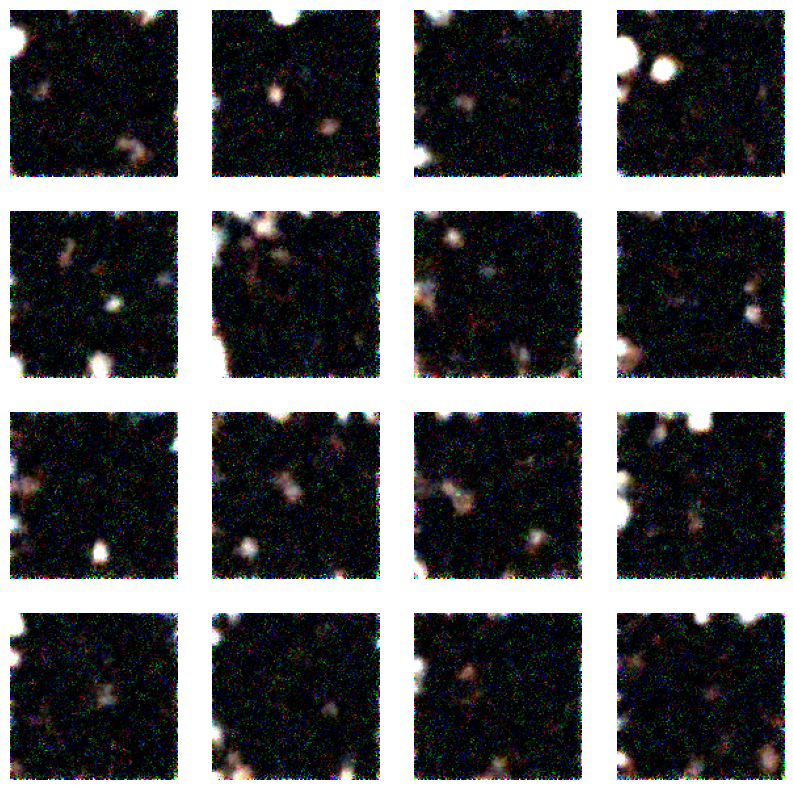

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import joblib

# データセットの前処理
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
])

# データセットの読み込み
dataset_path = 'F:/img_align_celeba'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# ディフュージョンモデルの定義
class DiffusionModel(nn.Module):
    def __init__(self, image_size, channels, timesteps):
        super(DiffusionModel, self).__init__()
        self.image_size = image_size
        self.channels = channels
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps).cuda()
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).cuda()
        
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, channels, kernel_size=3, padding=1),
        )

    def forward(self, x, t):
        return self.model(x)

    def sample(self, num_samples):
        x = torch.randn(num_samples, self.channels, self.image_size, self.image_size).cuda()
        for t in reversed(range(self.timesteps)):
            z = torch.randn_like(x) if t > 0 else 0
            x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_hat[t]) * self.forward(x, t)) / torch.sqrt(self.alpha[t]) + torch.sqrt(self.beta[t]) * z
        return x

# モデルの初期化
image_size = 128
channels = 3
timesteps = 1000
model = DiffusionModel(image_size, channels, timesteps).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# モデルの訓練
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.cuda()
        t = torch.randint(0, timesteps, (data.size(0),), device=data.device).long()
        noise = torch.randn_like(data)
        alpha_hat_t = model.alpha_hat[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_hat_t) * data + torch.sqrt(1 - alpha_hat_t) * noise
        optimizer.zero_grad()
        loss = nn.functional.mse_loss(model(x_t, t), noise)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}')

# 画像の生成
model.eval()
with torch.no_grad():
    samples = model.sample(16)
    samples = samples.cpu().numpy()

# 生成された画像の表示
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)))
    plt.axis('off')
plt.show()

In [4]:
joblib.dump(samples, 'samples.pkl')
joblib.dump(model, 'model.pkl')

['model.pkl']

In [7]:
samples = joblib.load("samples.pkl")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-31.738632..29.113314].


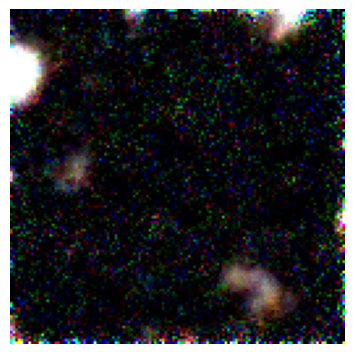

In [10]:
plt.figure(figsize=(20, 20))
for i in range(1):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)))
    plt.axis('off')
plt.show()